## Group member: Peilin Rao, Jake Ekoniak, Ananya Sampat, Dylan Shah, Nalin Chopra

# Data pipelining

Training the full-size U-Net takes a significant amount of time, yet we need to compare how different hyperparameter choices affect our model. Although not a perfect solution, we can reduce the model size in several ways to perform our tests, with the expectation that the results will reflect the behavior of the larger model.

In [1]:
# Import stuff
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torchmetrics import JaccardIndex
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
# Download the dataset containing images and annotations
#!wget https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz
#!wget https://thor.robots.ox.ac.uk/~vgg/data/pets/annotations.tar.gz

# make sure these two zip file are in the same folder
# unpack dataset into directoris
#!tar -xzf images.tar.gz
#!tar -xzf annotations.tar.gz

In [3]:
# Check out what we have (for linux and mac)
!ls images | head
!ls annotations | head

# for windows
# import os

# # List files in the "images" directory and show the first 10
# print("Images Directory:")
# images = os.listdir("images")[:10]
# for img in images:
#     print(img)

# # List files in the "annotations" directory and show the first 10
# print("\nAnnotations Directory:")
# annotations = os.listdir("annotations")[:10]
# for anno in annotations:
#     print(anno)

'ls' is not recognized as an internal or external command,
operable program or batch file.
'ls' is not recognized as an internal or external command,
operable program or batch file.


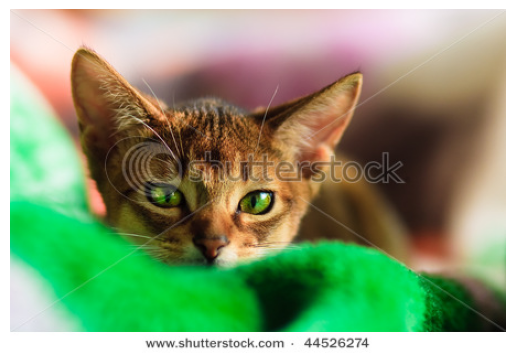

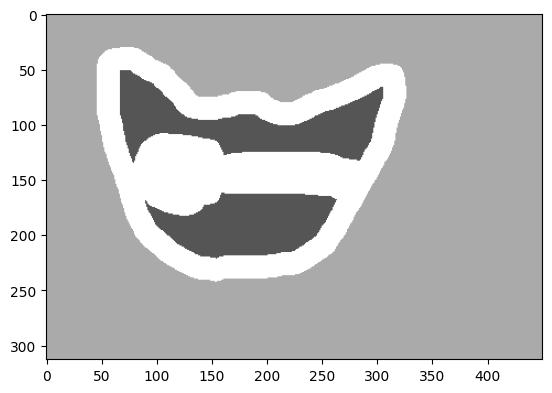

In [4]:
# Load and display an example image along with segmentation map
image_name = 'Abyssinian_101'
image = Image.open('images/' + image_name + '.jpg')
segmap = Image.open('annotations/trimaps/' + image_name + '.png')

plt.imshow(image)
plt.axis('off')
plt.show()
plt.imshow(np.array(segmap) / 3, cmap='gray', vmin=0.0, vmax=1.0)

In [5]:
# Take a closer look at what the segmentation map really is
# It has three values, one for the background, one for the outline, and one for the main body of the animal
print("--- shape ---")
print(np.array(segmap).shape)
print("\n--- contents ---")
print(np.array(segmap))
print("\n--- unique values ---")
print(np.unique(np.array(segmap)))

--- shape ---
(313, 450)

--- contents ---
[[2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 ...
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]]

--- unique values ---
[1 2 3]


## Transformations and augmentation

Do image horizontal flipping and color jittering.

Did hope to also do image rotation but cuda gives error and takes too long to train for grid search cross validation later

Initially made an error, that is the image transformation is not in sync with mask. This could cause serious problem

JointTransform ensure transformation happens together

In [6]:
import torch
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import numpy as np
from PIL import Image

image_size = 128

# convert image mask to tensor 
def mask_to_tensor(mask):
    mask_np = np.array(mask)
    return torch.from_numpy(mask_np).long()

# horizontal flip, color jittering
class JointTransform:
    def __init__(self, image_size):
        self.image_size = image_size
        # color jittering
        self.color_jitter = transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)

    def __call__(self, image, mask):
        # Resize
        image = TF.resize(image, (self.image_size, self.image_size))
        mask = TF.resize(mask, (self.image_size, self.image_size), interpolation=Image.NEAREST)

        # random horizontal flip
        if torch.rand(1) > 0.5:
            image = TF.hflip(image)
            mask = TF.hflip(mask)

        # color jittering only for image, not mask
        image = self.color_jitter(image)

        # to tensor
        image = TF.to_tensor(image)
        mask = mask_to_tensor(mask)

        # Normalize
        image = TF.normalize(image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

        return image, mask

# joint transformation augmentation function to be called
joint_transform = JointTransform(image_size=128)


## Dataset Class

In [7]:
IMAGES_DIR = "images"
TRIMAPS_DIR = "annotations/trimaps"
TRAINVAL_TXT = "annotations/trainval.txt"
TEST_TXT = "annotations/test.txt"

class OxfordPetsDataset(Dataset):
    ''' OxfordPetsDataset class '''
    def __init__(self, images_dir, masks_dir, joint_transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.joint_transform = joint_transform

        # List only .jpg files in the images directory
        self.image_names = [f for f in os.listdir(images_dir) if f.endswith('.jpg')]

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        image_path = os.path.join(self.images_dir, self.image_names[idx])
        mask_path = os.path.join(self.masks_dir, self.image_names[idx].replace('.jpg', '.png'))

        # Load image and mask
        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path)

        # Apply transformations if provided
        if self.joint_transform:
            image, mask = self.joint_transform(image, mask)

        # Adjust mask labels from 1,2,3 to 0,1,2
        mask = mask - 1
        mask = mask.long()

        return image, mask

    def get_item_name(self, idx):
        return os.path.join(self.images_dir, self.image_names[idx])

Let's instantiate a Dataset with our data and see some examples. This serves as a first check to make sure our transformations performed correctly.

In [8]:
# Instantiate dataset instance
dataset = OxfordPetsDataset(IMAGES_DIR, TRIMAPS_DIR, joint_transform=joint_transform)

### Check if Image Augmentation works correctly

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Original shape: torch.Size([3, 128, 128])
Resulting shape: (128, 128, 3)


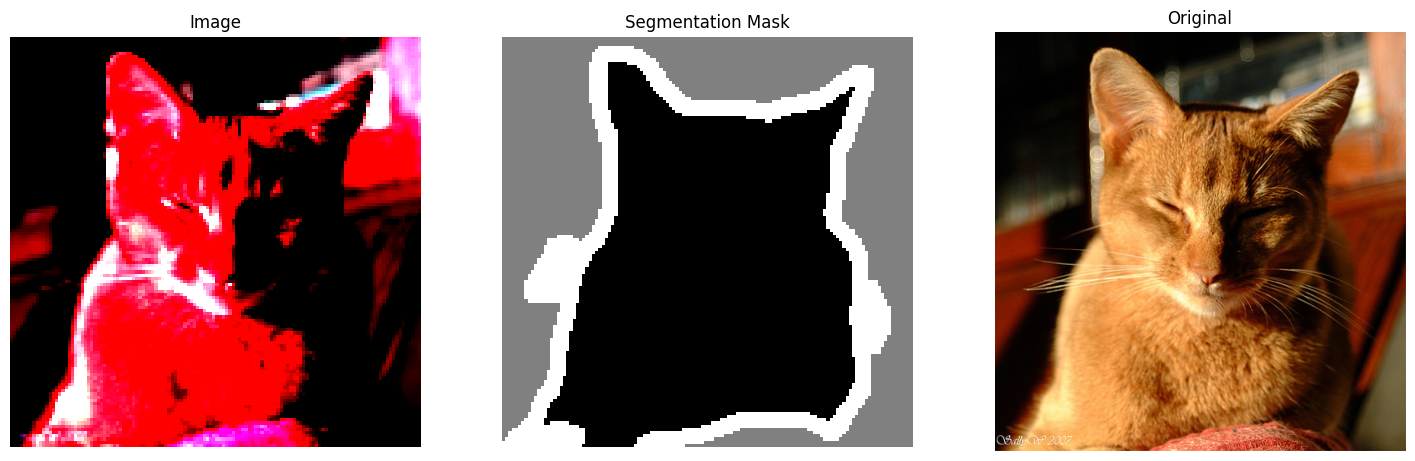

In [9]:
# Load an example
idx = 15
image, mask = dataset[idx]
name = dataset.get_item_name(idx)

print("Original shape:", image.shape)

# Resize and convert the image to a numpy array for display
image_np = image.permute(1, 2, 0).numpy()
print("Resulting shape:", image_np.shape)
mask_np = mask.numpy()

# Load the original image from the provided path
original = plt.imread(name)

# Create a figure with three subplots in one row
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.imshow(image_np)
plt.title("Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(mask_np, cmap="gray")
plt.title("Segmentation Mask")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(original)
plt.title("Original")
plt.axis("off")

plt.show()

Color jittering, horizontal flip, image shrinking are clearly visible!

## Dataloader(s) from Dataset

Because grid search is too slow, just use 10% of the dataset to train the data

In [10]:
# only 10% of training dataset
subset_fraction = 0.1
subset_size = int(subset_fraction * len(dataset))
dataset = torch.utils.data.Subset(dataset, range(subset_size))

# train test split 0.2 test  0.8 train & val split
total_size = len(dataset)
train_val_size = int(0.8 * total_size)
test_size = total_size - train_val_size

train_val_dataset, test_dataset = random_split(dataset, [train_val_size, test_size])

# 90% train, 10% val)
train_size = int(0.9 * len(train_val_dataset))
val_size = len(train_val_dataset) - train_size
train_dataset, val_dataset = random_split(train_val_dataset, [train_size, val_size])

print(f"Size of the dataset: {total_size}")
print(f"Size of the training set ({round(train_size/total_size, 2)}):    {train_size}")
print(f"Size of the validation set ({round(val_size/total_size, 2)}):  {val_size}")
print(f"Size of the test set ({round(test_size/total_size, 2)}):         {test_size}")

# DataLoaders
original_train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
original_val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
original_test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

Size of the dataset: 739
Size of the training set (0.72):    531
Size of the validation set (0.08):  60
Size of the test set (0.2):         148


We could use the dataloaders defined above, and I recommend using them once you narrow down on an optimal combination of hyperparameters, but Unets just take soo long to train so below I've defined some dataloaders on a subset of the full dataset that you can use to get started.

In [11]:
shrunken_size = len(dataset) * 0.6
train_val_size = int(0.8 * total_size)
test_size = total_size - train_val_size

train_val_dataset, test_dataset = random_split(dataset, [train_val_size, test_size])

# Now split train_val_dataset into training and validation subsets (e.g., 90% training, 10% validation)
train_size = int(0.9 * len(train_val_dataset))
val_size = len(train_val_dataset) - train_size
train_dataset, val_dataset = random_split(train_val_dataset, [train_size, val_size])

print(f"Size of the dataset: {total_size}")
print(f"Size of the training set({round(train_size/total_size, 2)}):    {train_size}")
print(f"Size of the validation set({round(val_size/total_size, 2)}):  {val_size}")
print(f"Size of the test set({round(test_size/total_size, 2)}):         {test_size}")

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

Size of the dataset: 739
Size of the training set(0.72):    531
Size of the validation set(0.08):  60
Size of the test set(0.2):         148


## Testing data loader on one batch (8 here)

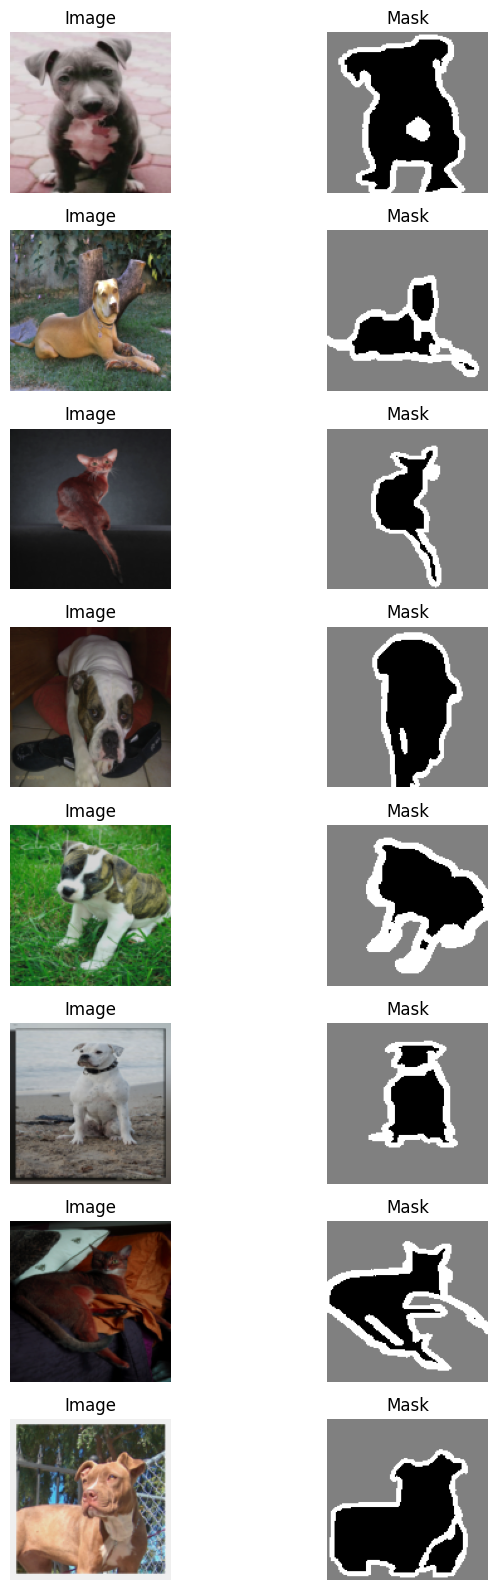

In [12]:
# We can print a whole batch from our dataloaders
def show_batch(images, masks):
    batch_size = images.size(0)
    fig, axes = plt.subplots(nrows=batch_size, ncols=2, figsize=(8, 2 * batch_size))

    # If only one sample, axes might be 1D so we ensure it is 2D
    if batch_size == 1:
        axes = [axes]

    for i in range(batch_size):
        # Change shape and denormalize
        image = images[i].permute(1, 2, 0)
        mean = torch.tensor([0.485, 0.456, 0.406])
        std = torch.tensor([0.229, 0.224, 0.225])
        image = image * std + mean
        image = image.clamp(0, 1)  # ensure the values are between 0 and 1

        axes[i][0].imshow(image.numpy())
        axes[i][0].set_title("Image")
        axes[i][0].axis("off")

        # Display mask - squeeze extra dimensions and convert to numpy
        mask = masks[i].squeeze().numpy()
        axes[i][1].imshow(mask, cmap='gray')
        axes[i][1].set_title("Mask")
        axes[i][1].axis("off")

    plt.tight_layout()
    plt.show()

# display the images and masks for one batch
for images, masks in test_loader:
    show_batch(images, masks)
    break

# Unet architecture

In [13]:
class DoubleConv(nn.Module):
    """
    helper function: two successive convolutional layer. each conv followed by BatchNorm and ReLU.
    """
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    """
    Main UNet model
    """
    def __init__(self, in_channels=3, out_channels=3, features=[64, 128, 256, 512]):
        super(UNet, self).__init__()
        # Encoder helper
        self.encoders = nn.ModuleList()
        for feature in features:
            self.encoders.append(DoubleConv(in_channels, feature))
            in_channels = feature

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Bottleneck helper
        self.bottleneck = DoubleConv(features[-1], features[-1] * 2)

        # Decoder helper
        self.upconvs = nn.ModuleList()
        self.decoders = nn.ModuleList()
        for feature in reversed(features):
            self.upconvs.append(nn.ConvTranspose2d(feature * 2, feature, kernel_size=2, stride=2))
            self.decoders.append(DoubleConv(feature * 2, feature))

        # final conv before output helper
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        ''' x is the "image tensor" (main implementation) '''
        skip_connections = []
        # Encoder
        for encoder in self.encoders:
            x = encoder(x)
            skip_connections.append(x)
            x = self.pool(x)  # after each double conv, do a pooling

        # Bottleneck
        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]  # reverse for skip connections

        # Decoder
        for idx in range(len(self.upconvs)):
            x = self.upconvs[idx](x)
            skip = skip_connections[idx]

            # shape need to be compatible with skip connection
            if x.shape != skip.shape:
                x = F.interpolate(x, size=skip.shape[2:])
            x = torch.cat((skip, x), dim=1) # concatenate skip connection with itself
            x = self.decoders[idx](x)

        return self.final_conv(x)

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# loss function

In [15]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, pred, target):
        
        pred = torch.softmax(pred, dim=1)  
        target_one_hot = F.one_hot(target, num_classes=pred.shape[1]).permute(0, 3, 1, 2).float()

        intersection = torch.sum(pred * target_one_hot, dim=(2, 3))
        union = torch.sum(pred, dim=(2, 3)) + torch.sum(target_one_hot, dim=(2, 3))

        dice_score = (2. * intersection + self.smooth) / (union + self.smooth)
        dice_loss = 1 - dice_score.mean()
        return dice_loss

In [16]:
class JaccardLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(JaccardLoss, self).__init__()
        self.smooth = smooth

    def forward(self, pred, target):
       
        pred = torch.softmax(pred, dim=1)
        target_one_hot = F.one_hot(target, num_classes=pred.shape[1]).permute(0, 3, 1, 2).float()

        intersection = torch.sum(pred * target_one_hot, dim=(2, 3))  
        union = torch.sum(pred, dim=(2, 3)) + torch.sum(target_one_hot, dim=(2, 3)) - intersection

        jaccard_score = (intersection + self.smooth) / (union + self.smooth)
        jaccard_loss = 1 - jaccard_score.mean()

        return jaccard_loss

# Hyperparameters

In [17]:
# Here we set which architecture we want and the hyperparameters

# Initialize model, loss, optimizer, and metric
model_Unet = UNet().to(device)
criterion = nn.CrossEntropyLoss()  # loss function. here use the default one
optimizer = optim.Adam(model_Unet.parameters(), lr=0.001)
jaccard = JaccardIndex(task="multiclass", num_classes=3).to(device) # score the performance (IoU) using jaccard

## Training

In [18]:
# 50 epochs to train. Each epoch goes through all the batches in the training set
num_epochs = 50
for epoch in range(num_epochs):
    model_Unet.train()
    running_loss = 0.0
    running_iou = 0.0

    for images, masks in train_loader:
        # Move data to device
        images = images.to(device)
        masks = masks.to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model_Unet(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        # prepare to print training loss
        running_loss += loss.item()

        # prepare to print Jaccard IoU
        preds = torch.argmax(outputs, dim=1)
        iou = jaccard(preds, masks)
        running_iou += iou.item()

    # Print training results
    epoch_loss = running_loss / len(train_loader)
    epoch_iou = running_iou / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, IoU: {epoch_iou:.4f}")

    # prepare to print loss and IoU for 
    model_Unet.eval()

    #initialize
    val_loss = 0.0
    val_iou = 0.0

    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model_Unet(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            iou = jaccard(preds, masks)
            val_iou += iou.item()

    val_loss = val_loss / len(val_loader)
    val_iou = val_iou / len(val_loader)

    # print val loss and IoU
    print(f"Validation Loss: {val_loss:.4f}, Validation IoU: {val_iou:.4f}")

KeyboardInterrupt: 

In [ ]:
total_params = sum(
    param.numel() for param in model_Unet.parameters()
)

print(f"The Model has {total_params} parameters")

The Model has 31037763 parameters


# Unet with depthwise separable convolution and bilinear upsampling

In [20]:
class FastDoubleConv(nn.Module):
    """
    Similar double conv helper but now for each convolution use depthwise separable conv
    """
    def __init__(self, in_channels, out_channels):
        super(FastDoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            # First convolution

            # each channel spatial conv
            nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1, groups=in_channels, bias=False),
            # 1*1 kernel conv that links all channels
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),

            # Second convolution. Same depthwise procedure
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, groups=out_channels, bias=False),
            nn.Conv2d(out_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class FastDecoderBlock(nn.Module):
    """
    Decoder block. bilinear upsampling and a 1x1 convolution to increase speed and reduce channel, followed by a fast double conv.
    """
    def __init__(self, in_channels, skip_channels):
        super(FastDecoderBlock, self).__init__()
        # Reduce the incoming channels so that it matches the skip connection channels.
        self.conv1x1 = nn.Conv2d(in_channels, skip_channels, kernel_size=1, bias=False)
        # After concatenation, the number of channels will be 2 * skip_channels.
        self.double_conv = FastDoubleConv(2 * skip_channels, skip_channels)

    def forward(self, x, skip):
        # bilinear upsampling to the size of the skip connection.
        x = F.interpolate(x, size=skip.shape[2:], mode='bilinear', align_corners=False)
        x = self.conv1x1(x)
        # Concatenate skip connection like what normal Unet does.
        x = torch.cat((skip, x), dim=1)
        x = self.double_conv(x)
        return x

class FastUNet(nn.Module):
    """
    Accelerated UNet using bilinear upsampling and depthwise separable convolutions.
    """
    def __init__(self, in_channels=3, out_channels=3, features=[64, 128, 256, 512]): # define number of feature for each hidden layer
        super(FastUNet, self).__init__()
        # Encoder helper
        self.encoders = nn.ModuleList()
        current_in_channels = in_channels
        for feature in features:
            self.encoders.append(FastDoubleConv(current_in_channels, feature))
            current_in_channels = feature

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Bottleneck helper
        self.bottleneck = FastDoubleConv(features[-1], features[-1] * 2)

        # Decoder helper
        self.decoders = nn.ModuleList()
        rev_features = list(reversed(features))
        # Connect bottleneck output to the first decoder block
        decoder_in_channels = [features[-1] * 2] + rev_features[:-1]  # Subsequent blocks use previous decoder output.
        for in_ch, skip_ch in zip(decoder_in_channels, rev_features):
            self.decoders.append(FastDecoderBlock(in_ch, skip_ch))

        # Final output convolution.
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        ''' main working part '''
        skip_connections = []
        # Encoder forward pass.
        for encoder in self.encoders:
            x = encoder(x)
            skip_connections.append(x)
            x = self.pool(x)

        # Bottleneck.
        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]  # Reverse for decoder

        # Decoder forward pass.
        for idx, decoder in enumerate(self.decoders):
            skip = skip_connections[idx]
            x = decoder(x, skip)

        x = self.final_conv(x)
        return x

In [21]:
# Here we set which architecture we want and the hyperparameters

# Initialize model, loss, optimizer, and metric
model_FastU = FastUNet().to(device)
criterion = nn.CrossEntropyLoss()  # For multi-class segmentation
optimizer = optim.Adam(model_FastU.parameters(), lr=0.001)
jaccard = JaccardIndex(task="multiclass", num_classes=3).to(device)

In [22]:
# Run the Training Loop. Almost the same as the previous traditional Unet. 
# Will create a Wrapper to make this process easier I promise
num_epochs = 50
for epoch in range(num_epochs):
    model_FastU.train()
    running_loss = 0.0
    running_iou = 0.0

    for images, masks in train_loader:
        # Move data to device
        images = images.to(device)
        masks = masks.to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model_FastU(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        # Update running loss
        running_loss += loss.item()

        # Calculate IoU
        preds = torch.argmax(outputs, dim=1)
        iou = jaccard(preds, masks)
        running_iou += iou.item()

    # Print epoch results
    epoch_loss = running_loss / len(train_loader)
    epoch_iou = running_iou / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, IoU: {epoch_iou:.4f}")

    # Validation phase
    model_FastU.eval()
    val_loss = 0.0
    val_iou = 0.0

    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model_FastU(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            iou = jaccard(preds, masks)
            val_iou += iou.item()

    val_loss = val_loss / len(val_loader)
    val_iou = val_iou / len(val_loader)
    print(f"Validation Loss: {val_loss:.4f}, Validation IoU: {val_iou:.4f}")

KeyboardInterrupt: 

# Visualization of Unet vs Fast Unet

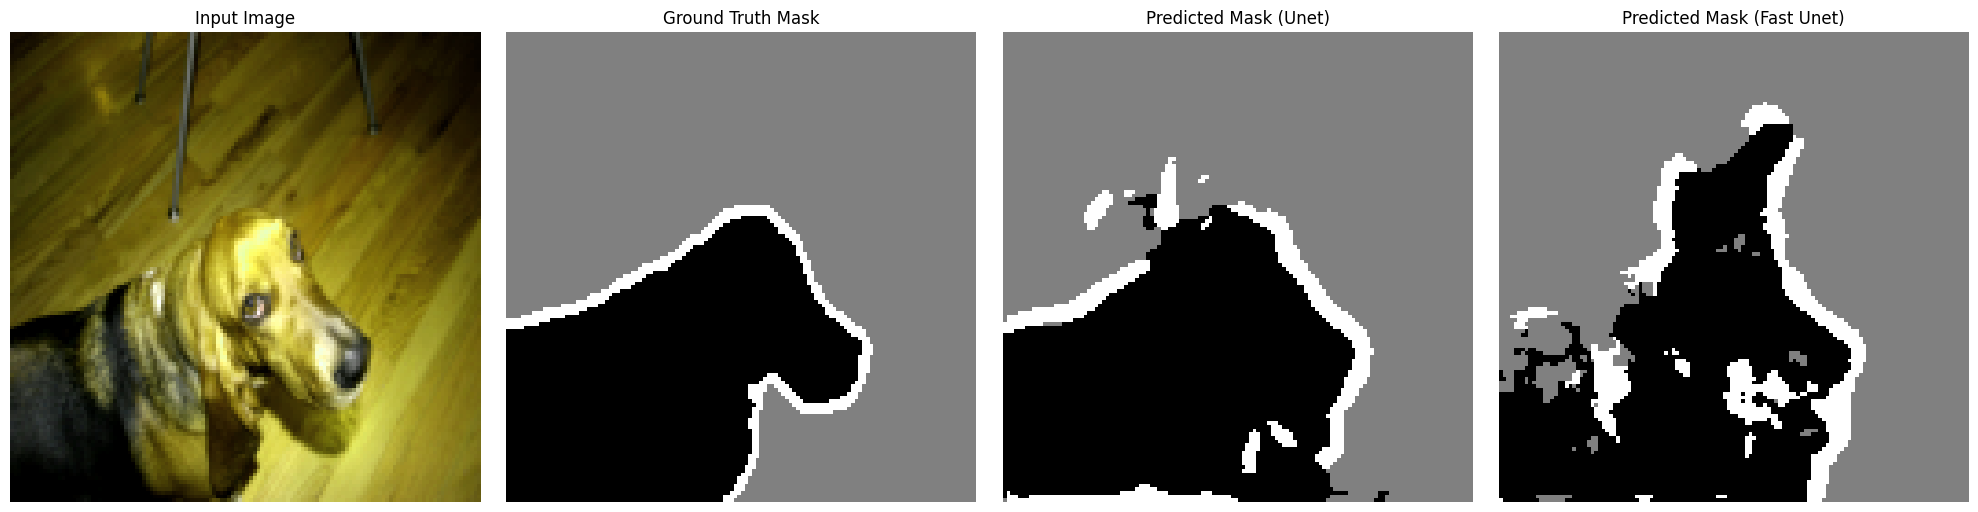

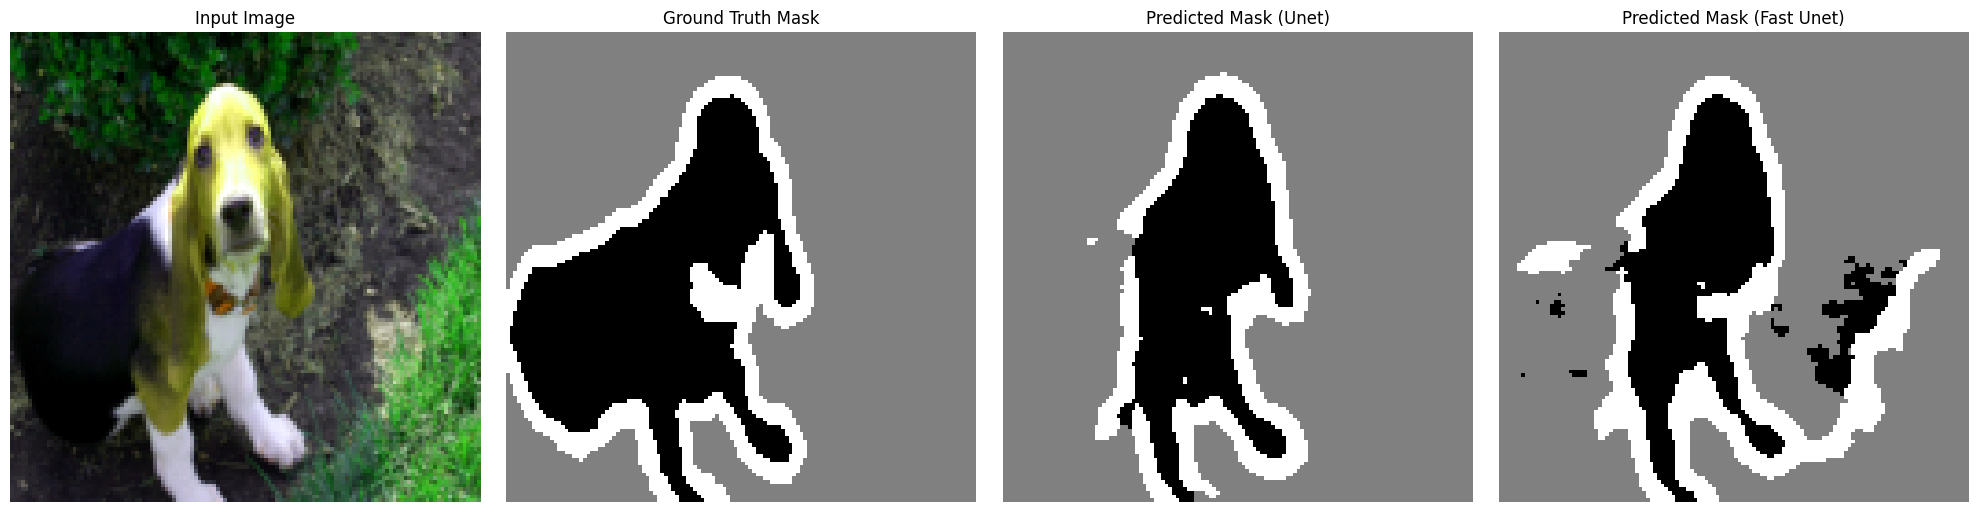

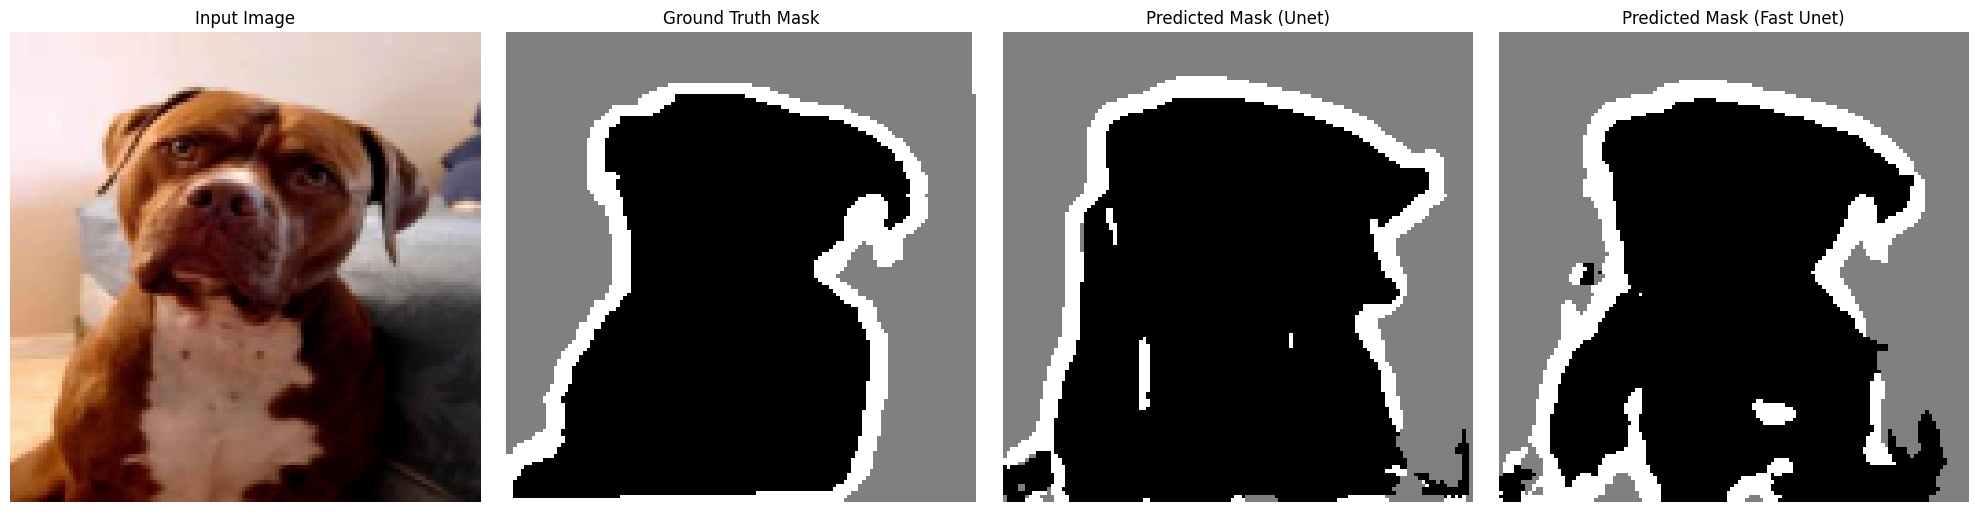

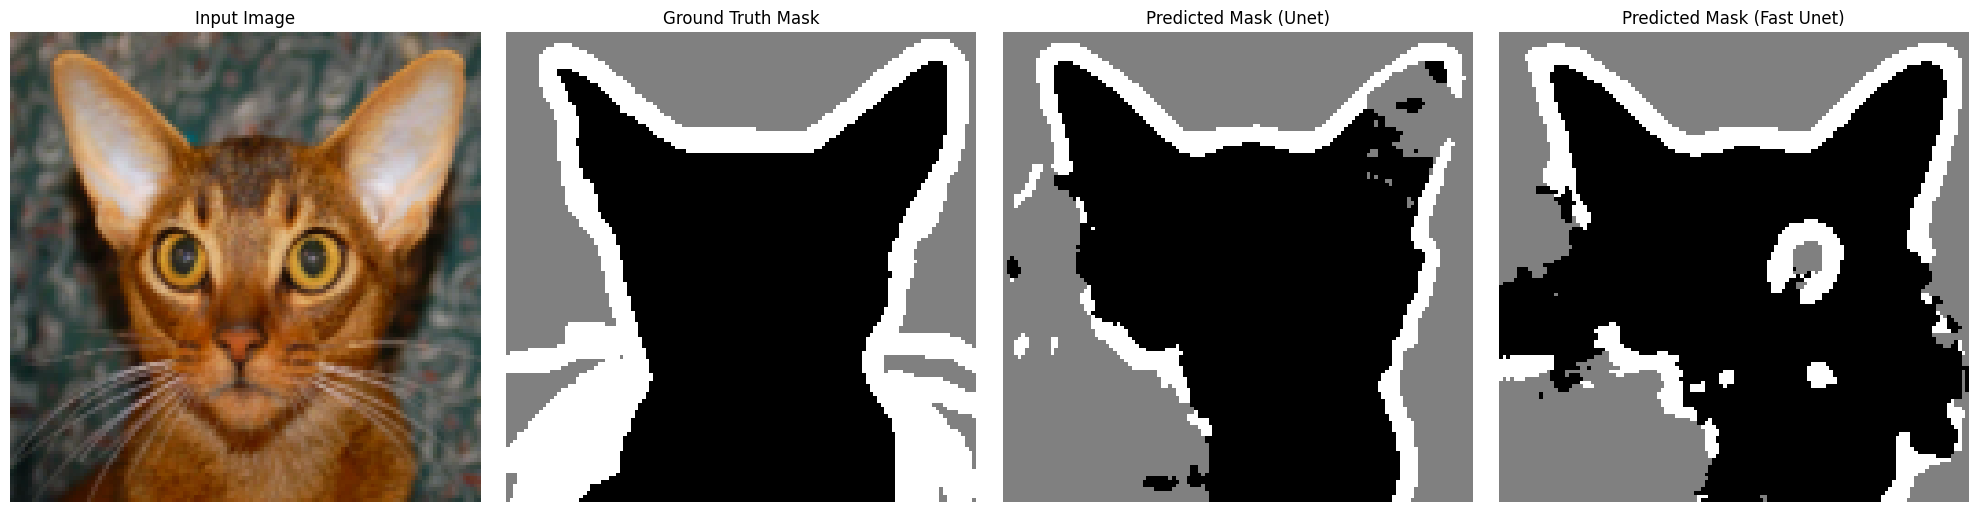

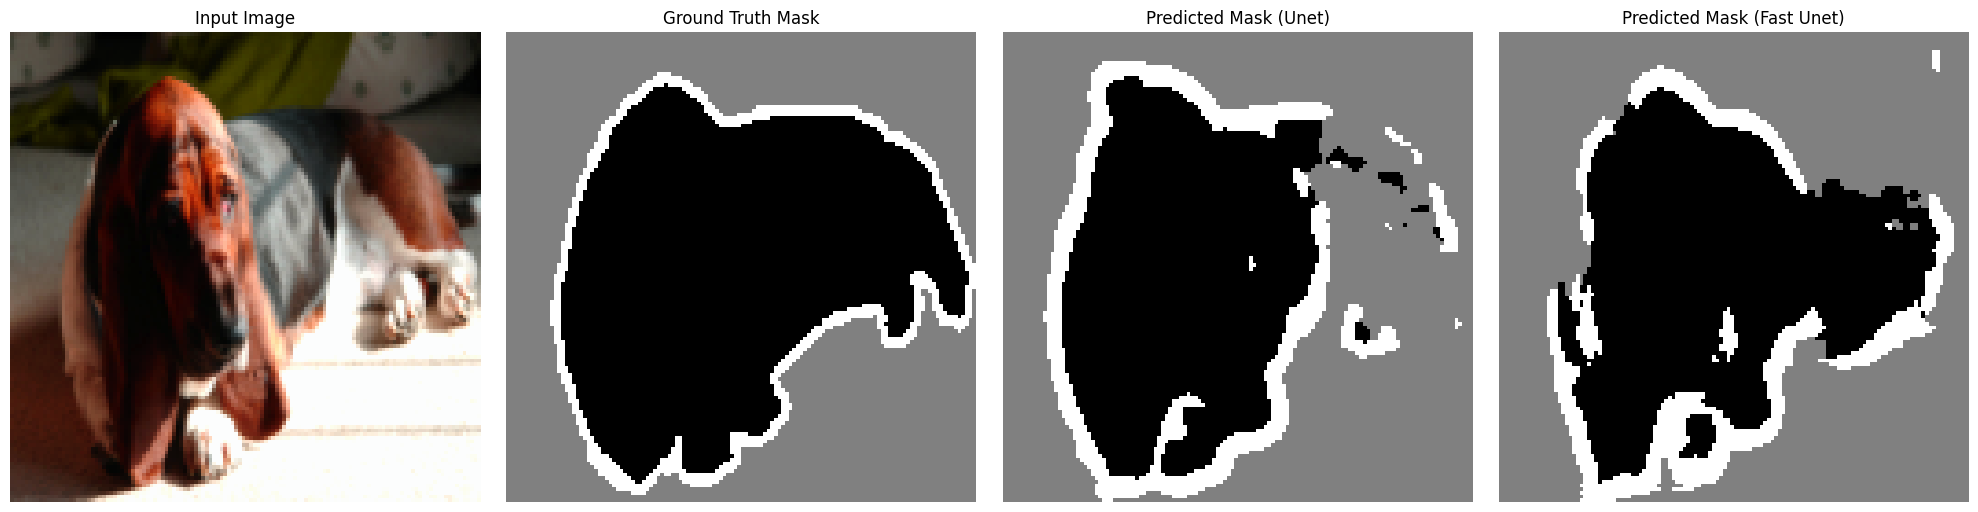

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def visualize_predictions(model_unet, model_improved, dataloader, num_images=5):
    model_unet.eval()
    model_improved.eval()
    images_shown = 0
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            
            # Get predictions from both models
            outputs_unet = model_unet(images)
            outputs_improved = model_improved(images)
            preds_unet = torch.argmax(outputs_unet, dim=1).cpu().numpy()
            preds_improved = torch.argmax(outputs_improved, dim=1).cpu().numpy()
            
            # Move images and ground truth masks to CPU for processing
            images = images.cpu().numpy()
            masks = masks.cpu().numpy()

            for i in range(images.shape[0]):
                # Denormalize and reformat the image from (C, H, W) to (H, W, C)
                img = np.transpose(images[i], (1, 2, 0))
                img = std * img + mean
                img = np.clip(img, 0, 1)

                # Get the ground truth and predictions for the current image
                gt_mask = masks[i].squeeze()
                pred_mask_unet = preds_unet[i].squeeze()
                pred_mask_improved = preds_improved[i].squeeze()

                # Create a figure with four subplots
                fig, axes = plt.subplots(1, 4, figsize=(20, 5))
                axes[0].imshow(img)
                axes[0].set_title("Input Image")
                axes[0].axis("off")

                axes[1].imshow(gt_mask, cmap="gray")
                axes[1].set_title("Ground Truth Mask")
                axes[1].axis("off")

                axes[2].imshow(pred_mask_unet, cmap="gray")
                axes[2].set_title("Predicted Mask (Unet)")
                axes[2].axis("off")

                axes[3].imshow(pred_mask_improved, cmap="gray")
                axes[3].set_title("Predicted Mask (Fast Unet)")
                axes[3].axis("off")

                plt.tight_layout()
                plt.show()

                images_shown += 1
                if images_shown >= num_images:
                    return

# Visualize predictions using both models on test images
visualize_predictions(model_Unet, model_FastU, test_loader, num_images=5)


The visualization compares the standard U-Net segmentation with the ‘Fast U-Net’ that uses depthwise convolutions and bilinear upsampling. The standard U-Net output seems slightly closer to the ground truth mask than the predicted pixels have a tighter outline around the animal's shape. The Fast U-Net gets the overall shape of the segmentation outline correct but has small scattered artifacts throughout, which could be a result of the lighter-weight architecture and simpler upsampling method. However, the Fast U-Net does get the majority of the animal's body correct, so depthwise convolutions and bilinear upsampling are a reasonable tradeoff for achieving some efficiency in segmentation tasks.

In [24]:
total_params = sum(
    param.numel() for param in model_Unet.parameters()
)

print(f"The Unet Model has {total_params} parameters")

total_params = sum(
    param.numel() for param in model_FastU.parameters()
)

print(f"The Fast Unet Model has {total_params} parameters")

The Unet Model has 31037763 parameters
The Fast Unet Model has 3898462 parameters


31037763 - 3898462 = 27139301 saved by using depthwise separable convolution in unet, plus it is more accurate and it trains faster!!!
That is why we'll use the "FastUnet" to do the grid search. It is literally impossible to do grid search on traditional Unet not only because it is too slow, but that my computer's memory would worn out quickly. 

# wrapper to make training grid search CV easier

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.metrics import jaccard_score
import numpy as np

In [26]:
class UNetWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self,
                 model_class,          # the UNet architecture (e.g. UNet or FastUNet)
                 in_channels=3,
                 num_classes=3,
                 lr=0.001,
                 weight_decay=0.0,
                 optimizer_name='adam',
                 batch_size=32,
                 num_epochs=20,
                 device=None,
                 verbose=False,
                 criterion='cross_entropy'):  # Parameter for loss function selection
        """
        Initializes the UNet wrapper.

        Parameters:
          model_class (class)
          in_channels (int):
          num_classes (int):
          lr (float): Learning rate
          weight_decay (float): L2 penalty
          optimizer_name (str): 'adam' or 'sgd'.
          batch_size (int): Batch size.
          num_epochs (int): training epochs.
          criterion (str): loss function for training and backprop ('cross_entropy', 'dice', or 'jaccard').
        """
        self.model_class = model_class
        self.in_channels = in_channels
        self.num_classes = num_classes
        self.lr = lr
        self.weight_decay = weight_decay
        self.optimizer_name = optimizer_name
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        self.verbose = verbose
        self.criterion = criterion

        if device is None:
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        else:
            self.device = device

        # Choose the loss function to be used based on the criterion.
        if criterion.lower() == 'cross_entropy':
            self.criterion_fn = nn.CrossEntropyLoss()
        elif criterion.lower() == 'dice':
            self.criterion_fn = DiceLoss()
        elif criterion.lower() == 'jaccard':
            self.criterion_fn = JaccardLoss()
        else:
            raise ValueError(f"Unsupported scoring method: {criterion}")

    def fit(self, X, y):
        """
        Fits the UNet model
        """
        # Convert numpy arrays to tensors if necessary
        if not torch.is_tensor(X):
            X = torch.tensor(X, dtype=torch.float32)
        if not torch.is_tensor(y):
            y = torch.tensor(y, dtype=torch.long)

        # Create a dataset and DataLoader
        dataset = TensorDataset(X, y)
        train_loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

        # Initialize the model and move it to the chosen device
        self.model_ = self.model_class().to(self.device)

        # Set up the optimizer
        if self.optimizer_name.lower() == 'adam':
            self.optimizer = optim.Adam(self.model_.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        elif self.optimizer_name.lower() == 'sgd':
            self.optimizer = optim.SGD(self.model_.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        else:
            raise ValueError(f"Unsupported optimizer: {self.optimizer_name}")

        # Training loop
        self.model_.train()
        for epoch in range(self.num_epochs):
            running_loss = 0.0
            for images, masks in train_loader:
                images, masks = images.to(self.device), masks.to(self.device)
                self.optimizer.zero_grad()
                outputs = self.model_(images)
                loss = self.criterion_fn(outputs, masks)  # Use the selected loss function
                loss.backward()
                self.optimizer.step()
                running_loss += loss.item()

            if self.verbose:
                avg_loss = running_loss / len(train_loader)
                print(f"Epoch [{epoch+1}/{self.num_epochs}], Loss: {avg_loss:.4f}")

        # Record the unique classes for later use
        y_np = y.cpu().numpy() if torch.is_tensor(y) else y
        self.classes_ = np.unique(y_np)
        
        return self

    def predict(self, X):
        if not torch.is_tensor(X):
            X = torch.tensor(X, dtype=torch.float32)
        loader = DataLoader(X, batch_size=self.batch_size, shuffle=False)
        self.model_.eval()
        all_preds = []
        with torch.no_grad():
            for batch in loader:
                images = batch[0] if isinstance(batch, (list, tuple)) else batch
                images = images.to(self.device)
                outputs = self.model_(images)
                preds = torch.argmax(outputs, dim=1)
                all_preds.append(preds.cpu())
        return torch.cat(all_preds, dim=0).numpy()

    def score(self, X, y):
        """Uses Jaccard IoU as scoring metric """
        if not torch.is_tensor(y):
            y = torch.tensor(y, dtype=torch.long)
        preds = self.predict(X)
        preds_flat = preds.ravel()
        y_flat = y.cpu().numpy().ravel() if torch.is_tensor(y) else y.ravel()
        
        # Compute the IoU (Jaccard score). 
        # Use average='macro' for the unweighted mean IoU across classes,
        # or use average=None to get the IoU for each class.
        return jaccard_score(y_flat, preds_flat, average='macro')


## Grid Search

In [27]:
from sklearn.model_selection import GridSearchCV

def dataset_to_numpy(dataset):
    X_list, y_list = [], []
    for img, mask in dataset:
        X_list.append(img.numpy())
        y_list.append(mask.numpy())
    return np.stack(X_list), np.stack(y_list)

X_train, y_train = dataset_to_numpy(train_dataset)

# Suppose you want to test different learning rates and batch sizes.
# here I only test one grid point to see if it works

# recall that the hidden layers have features=[64, 128, 256, 512]
param_grid = {
    'lr': [0.001, 0.01, 0.0001],  
    'weight_decay': [0.0, 0.0001, 0.01],  
    'optimizer_name': ['adam'], 
    'batch_size': [32, 64], 
    'num_epochs': [50, 100], 
    'criterion': ['cross_entropy', 'dice'] 
}


# Sample use of grid search cross validation
estimator = UNetWrapper(model_class=FastUNet,
                        in_channels=3,
                        num_classes=3,
                        verbose=True,)

#grid_search = GridSearchCV(estimator, param_grid, cv=2, verbose=3)  # cv = 2 since model is too large to train
#grid_search.fit(X_train, y_train)
#print("Best parameters:", grid_search.best_params_)



I pause this grid search since it is taking forever, but the existing log would be sufficient
If the last commented out three lines of code is run it performs the grid search. The problem is that my laptop, although it has 4070 GPU, does not have a lot of memory, and the training becomes slower and slower and slower... to the point I can take it no more. The output log is in "gridsearch_output.txt"


# Visualize Grid search

In [28]:
import re
import pandas as pd

# File name containing the grid search output
log_filename = "gridsearch_output.txt"

# List to store parsed results
results = []

# Regex pattern to match the grid line
pattern = re.compile(
    r"\[CV\s+\d+/\d+\]\s+END\s+(.*?);\s*,?\s*score=([0-9.]+)\s+total time=\s*([0-9.]+)min"
)

# Read and parse the file
with open(log_filename, "r") as f:
    for line in f:
        line = line.strip()
        match = pattern.search(line)
        if match:
            params_str = match.group(1)  # parameters part
            score = float(match.group(2))
            total_time = float(match.group(3))
            # Parse the parameters; they are comma separated key=value pairs
            params = {}
            for part in params_str.split(","):
                part = part.strip()
                if "=" in part:
                    key, value = part.split("=")
                    key = key.strip()
                    value = value.strip()
                    # Convert to int or float if possible
                    try:
                        if "." in value:
                            value = float(value)
                        else:
                            value = int(value)
                    except Exception:
                        pass
                    params[key] = value
            # Add score and total_time to the dictionary
            params["score"] = score
            params["total_time"] = total_time
            results.append(params)

# Create a DataFrame from the parsed results
df = pd.DataFrame(results)

# Define the grid parameter keys
grid_keys = ["batch_size", "criterion", "lr", "num_epochs", "optimizer_name", "weight_decay"]

# Group by the grid parameters and average over the CV folds
grouped = df.groupby(grid_keys, as_index=False).mean()

# Create separate DataFrames for score and total time
score_grid = grouped[grid_keys + ["score"]]
time_grid = grouped[grid_keys + ["total_time"]]

# Rank the score and the total time:
# For score, higher is better (descending ranking)
score_grid["score_rank"] = score_grid["score"].rank(ascending=False, method="min")
# For total time, lower is better (ascending ranking)
time_grid["time_rank"] = time_grid["total_time"].rank(ascending=True, method="min")

# Sort the grids by the ranking columns if desired
score_grid_sorted = score_grid.sort_values("score_rank")
time_grid_sorted = time_grid.sort_values("time_rank")

# Output the grids
print("Score Grid with Ranking:")
print(score_grid_sorted.to_string(index=False))

print("\nTotal Time Grid with Ranking (in minutes):")
print(time_grid_sorted.to_string(index=False))


Score Grid with Ranking:
 batch_size     criterion     lr  num_epochs optimizer_name  weight_decay  score  score_rank
         32          dice 0.0100         100           adam        0.0000 0.5980         1.0
         32 cross_entropy 0.0100         100           adam        0.0001 0.5950         2.0
         32 cross_entropy 0.0100         100           adam        0.0000 0.5940         3.0
         32          dice 0.0100          50           adam        0.0000 0.5825         4.0
         32          dice 0.0100         100           adam        0.0001 0.5810         5.0
         32 cross_entropy 0.0010         100           adam        0.0000 0.5750         6.0
         32 cross_entropy 0.0100          50           adam        0.0000 0.5745         7.0
         32          dice 0.0100          50           adam        0.0001 0.5725         8.0
         32          dice 0.0010          50           adam        0.0001 0.5710         9.0
         32 cross_entropy 0.0010          50 

# Visualize of previous FastUnet vs best FastUnet

In [29]:
# Model trained with previous parameters
model_previous_fastU = UNetWrapper(
    model_class=FastUNet,
    in_channels=3,
    num_classes=3,
    lr=0.001,
    weight_decay=0.0,
    optimizer_name='adam',
    batch_size=8,
    num_epochs=50,
    verbose=True,
    criterion='cross_entropy'
)

# Model trained with best grid search parameters
model_best_FastU = UNetWrapper(
    model_class=FastUNet,
    in_channels=3,
    num_classes=3,
    lr=0.01,
    weight_decay=0.0,
    optimizer_name='adam',
    batch_size=32,
    num_epochs=100,
    verbose=True,
    criterion='dice'
)




In [ ]:
from torchsummary import summary
# Replace 256, 256 with the actual height and width of your input images.
summary(model_previous_fastU.model_, input_size=(3, 256, 256))


In [30]:
# Train both models on the training data
model_previous_fastU.fit(X_train, y_train)
model_best_FastU.fit(X_train, y_train)

# Get one batch from your test loader
images_batch, masks_batch = next(iter(test_loader))

# Number of test images to display (make sure it's ≤ batch size)
num_images_to_display = 5

# Create a figure with one row per image and three columns:
# Column 1: Ground Truth, 
# Column 2: Prediction by previous FastUnet, 
# Column 3: Prediction by Best FastUnet by grid search.
fig, axes = plt.subplots(num_images_to_display, 3, figsize=(15, 5 * num_images_to_display))

# Loop over the first few images in the batch
for i in range(num_images_to_display):
    # Get ground truth for the test image
    gt = masks_batch[i].numpy()  # Convert tensor to numpy array if needed

    # Get predictions from each model (predict expects a batch, so we use images_batch[i:i+1])
    pred1 = model_previous_fastU.predict(images_batch[i:i+1])[0]
    pred2 = model_best_FastU.predict(images_batch[i:i+1])[0]

    # Plot the ground truth segmentation mask
    axes[i, 0].imshow(gt, cmap='gray')
    axes[i, 0].set_title("Ground Truth")
    axes[i, 0].axis('off')
    
    # Plot prediction from the first model
    axes[i, 1].imshow(pred1, cmap='gray')
    axes[i, 1].set_title("Prediction: Previous Fast Unet")
    axes[i, 1].axis('off')
    
    # Plot prediction from the second model
    axes[i, 2].imshow(pred2, cmap='gray')
    axes[i, 2].set_title("Prediction: Best Fast Unet by Grid Search")
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()


Epoch [1/50], Loss: 0.7662


KeyboardInterrupt: 

 The figure displayed above compares the performance of two Fast U-Net models: the previous version and  the Fast U-Net optimized using grid search compared to the ground truth. The first column is the  ground truth, used as a reference in the segmentation task. The second column, the previous Fast  U-Net predictions, has some inaccuracies at the object boundaries and is gaps and lack of detail in  capturing. The third column, the predictions from the optimized Fast U-Net, has more accurate boundaries  and is in better register with the ground truth than the previous model, which was improved through hyperparameter  tuning. The optimized model reduces noise and improves edge definition.

## ROC Analysis for each class

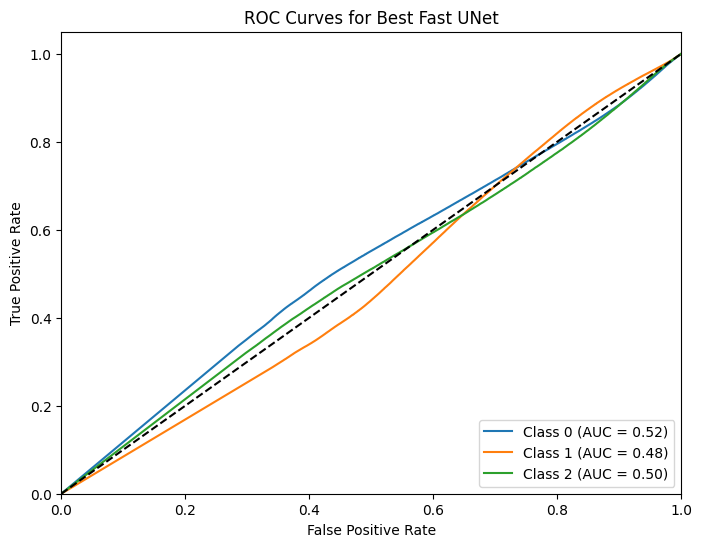

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

def compute_roc_from_loader(model, loader, device, num_classes):
    """
    Computes ROC curves and AUC scores for each class using pixel-wise softmax outputs.
    """
    model.model_.eval() # no need to retrain the model. just use the exhiting trained one
    all_probs = []
    all_masks = []
    with torch.no_grad():
        for images, masks in loader:
            images = images.to(device)
            outputs = model.model_(images)  
            probs = torch.softmax(outputs, dim=1).cpu().numpy() 
            masks = masks.cpu().numpy()
            
            B, C, H, W = probs.shape
            # Reshape so each pixel is a sample
            all_probs.append(probs.reshape(B, C, -1))
            all_masks.append(masks.reshape(B, -1))  
    
    all_probs = np.concatenate(all_probs, axis=0).reshape(-1, num_classes)
    all_masks = np.concatenate(all_masks, axis=0).flatten()
    # One-hot encode the ground truth for a one-vs-rest approach
    all_masks_onehot = label_binarize(all_masks, classes=list(range(num_classes)))
    
    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(all_masks_onehot[:, i], all_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    return fpr, tpr, roc_auc

# device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_classes = 3  # update this based on your setup

# Compute ROC curves for model_best_FastU using the test data from test_loader
fpr, tpr, roc_auc = compute_roc_from_loader(model_best_FastU, test_loader, device, num_classes)

# Plot the ROC curves for each class: 0 background 1 boarder 2 main body 
plt.figure(figsize=(8, 6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], 'k--')  # chance line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Best Fast UNet")
plt.legend(loc="lower right")
plt.show()


The figures above depict one‐versus‐all ROC curves for each segmentation class, namely background (AUC = 0.52), boundary (AUC = 0.48) and main body (AUC = 0.50), all of which are located close to the diagonal, implying that the performance is virtually random. The boundary class is especially difficult due to the narrowness and low pixel count of the region, which makes it harder to distinguish from other classes; on the other hand, the AUC of the background is only slightly higher than random, which suggests that the model has only limited ability to distinguish between the background and other classes. In general, these flat ROC curves further support the contention that the model has a hard time in distinguishing between the classes and the source of this difficulty can be attributed to class imbalance (i.e., a large number of pixels belonging to the background) and the thin boundary region